# Using [Intake-ESM's](https://intake-esm.readthedocs.io/en/latest/) Derived Variable Functionality

## What is a "Derived Variable"
A "derived variable" in this case is a variable that doesn't itself exist in an [intake-esm](https://intake-esm.readthedocs.io/en/latest/) catalog, but can be computed (i.e., "derived") from variables that do exist in the catalog. 
Currently, the derived variable implementation requires variables on the same grid, etc.; i.e., it assumes that all variables involved can be merged within **the same dataset**. 

An example of a derived variable could be temperature in degrees Fahrenheit. Often times, climate model models write temperature in Celsius or Kelvin, but the user may want degrees Fahrenheit!
This is a really simple example; derived variables could include more sophsticated diagnostic output like aggregations of terms in a tracer budget or gradients in a particular field.

A traditional workflow for "derived variables" might consist of the following:
* Load the data
* Apply some function to the loaded datasets
* Plot the output


But what if we could couple those first two steps? What if we could have some set of **variable definitions**, consisting of variable requirements, such as `dependent variables`, and a function which derives the quantity. This is what the `derived_variable` funtionality offers in `intake-esm`! This enables users to share a "registry" of derived variables across catalogs!

Let's get started with an example!

## Imports

In [4]:
import intake
import numpy as np

from intake_esm.derived import DerivedVariableRegistry

## How to add a Derived Variable
Let's compute a derived variable - wind speed! This can be derived from using the zonal (`U`) and meridional (`V`) components of the wind.

In [5]:
def calc_wind_speed(u, v):
    return np.sqrt(u ** 2 + v ** 2)

### Creating our Derived Variable Registry
We need to instantiate our derived variable registry, which will store our derived variable information! We use the variable `dvr` for this (**D**erived**V**ariable**R**egistry).

In [6]:
dvr = DerivedVariableRegistry()

In order to register this derived variable we need to add a [decorator](https://www.python.org/dev/peps/pep-0318/) for our function, as seen below. This allows us to define our derived variable, dependent variables, and the function associated with the calculation.

In [7]:
@dvr.register(variable='wind_speed', query={'variable': ['U', 'V']})
def calc_wind_speed(ds):
    ds['wind_speed'] = np.sqrt(ds.U ** 2 + ds.V ** 2)
    return ds

You'll notice `dvr` now has a registered variable, `wind_speed`, which was defined in the cell above!

In [8]:
dvr

DerivedVariableRegistry({'wind_speed': DerivedVariable(func=<function calc_wind_speed at 0x10f24a700>, variable='wind_speed', query={'variable': ['U', 'V']})})

### Loading in a Derived Variable Registry from File
You can load your derived variables from a module as well!

Within the file `my_registry.py`, we have the following, which mirrors the previous few cells:

```python
from intake_esm.derived import DerivedVariableRegistry

dvr = DerivedVariableRegistry()

@dvr.register(variable='wind_speed', query={'variable': ['U', 'V']})
def calc_wind_speed(ds):
    ds['wind_speed'] = np.sqrt(ds.U ** 2 + ds.V ** 2)
    return ds
```

We can now load `my_registry.py` into our notebook! We use the following syntax to load in that registry:

```python
dvr = DerivedVariableRegistry.load('my_registry')
dvr
```

```
DerivedVariableRegistry({'wind_speed': DerivedVariable(func=<function calc_wind_speed at 0x1aac905e0>, variable='wind_speed', query={'variable': ['U', 'V']})})
```

## Read in Data with our Registry
In this case, we will use data from the CESM Large Ensemble (LENS). This is a climate model ensemble, a subset of which is hosted on the AWS Cloud. If you are interested in learning more about this dataset, check out the [LENS on AWS documentation page](https://ncar.github.io/cesm-lens-aws/).

We load in our derived variable catalog using the `registry` argument.

In [12]:
data_catalog = intake.open_esm_datastore(
    'https://raw.githubusercontent.com/NCAR/cesm-lens-aws/master/intake-catalogs/aws-cesm1-le.json',
    registry=dvr,
)

You'll notice we have a new field - `derived_variable` which has 1 unique value.

In [13]:
data_catalog

,unique
variable,78
long_name,75
component,5
experiment,4
frequency,6
vertical_levels,3
spatial_domain,5
units,25
start_time,12
end_time,13


Let's also subset for monthly frequency, as well as the 20th century (20C) and RCP 8.5 (RCP85) experiments.

In [18]:
catalog_subset = data_catalog.search(
    variable=['wind_speed'], frequency='monthly', experiment='RCP85'
)

catalog_subset

,unique
variable,2
long_name,2
component,1
experiment,4
frequency,4
vertical_levels,1
spatial_domain,1
units,1
start_time,7
end_time,7


### Calling `to_dataset_dict` to Load in the Data
We load in the data, which lazily adds our calculation for `wind_speed` to the datasets!

In [45]:
dsets = catalog_subset.to_dataset_dict(
    xarray_open_kwargs={'backend_kwargs': {'storage_options': {'anon': True}}}
)
dsets.keys()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


dict_keys(['atm.RCP85.monthly', 'atm.HIST.monthly', 'atm.20C.monthly', 'atm.RCP85.hourly6-2071-2080', 'atm.CTRL.monthly', 'atm.RCP85.hourly6-2026-2035', 'atm.20C.hourly6-1990-2005'])

Let's look at single dataset from this dictionary of datasets... using the key `atm.CTRL.monthly`

In [46]:
ds = dsets['atm.CTRL.monthly']

## Apply an Annual Mean Calculation
Let's apply an annual average to the data - since all the years are 365 days long, we do not need any special weighting

You'll notice upon reading in the dataset, we have three variables:
* `U`
* `V`
* `wind_speed`

In [47]:
annual_mean = ds.groupby('time.year').mean('time')

### Plot the Output
We can use the plotting functions within [`Xarray`](http://xarray.pydata.org/en/stable/) to view the output!

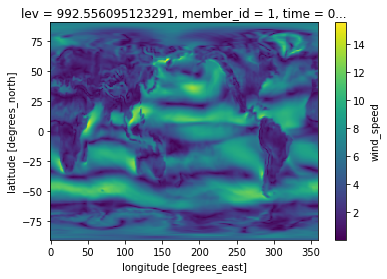

In [50]:
ds.wind_speed.isel(member_id=0, time=0, lev=-1).plot();